# Model 2: Stacking

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, f1_score, fbeta_score, make_scorer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.compose import make_column_transformer

from xgboost import XGBClassifier



pd.set_option('display.float_format', lambda x: '%.2f' % x)
RSEED = 42

In [2]:
df = pd.read_csv('data/cleaned/train.csv')
df_test = pd.read_csv('data/cleaned/test.csv')
df.head()


,district,client_id,client_catg,region,target,reading_remarque,counter_coeff,consommation_sum,consommation_per_month,months_number,elec,gaz
0,63,train_Client_33962,11,101,0.00,6.00,1.00,453.08,113.27,4.00,1,1
1,62,train_Client_32174,11,301,0.00,6.00,1.00,25.10,8.11,3.40,1,1
2,69,train_Client_18868,11,107,0.00,6.00,1.00,290.02,70.77,4.00,1,1
3,62,train_Client_39728,11,310,0.00,6.00,1.00,590.89,144.65,4.11,1,0
4,60,train_Client_34246,11,101,0.00,6.00,1.00,476.91,120.93,3.96,1,1


## Split Target, Drop ID

In [3]:
y_train = df['target']
X_train = df.drop(['target', 'client_id', 'consommation_per_month'], axis=1)

In [4]:
# Helper: Check specific columns:
X_train.iloc[:,5].sort_values(ascending=False).nunique()

93148

In [5]:
# Helper (compare X_train and X_test below):
X_train.head(2)

,district,client_catg,region,reading_remarque,counter_coeff,consommation_sum,months_number,elec,gaz
0,63,11,101,6.00,1.00,453.08,4.00,1,1
1,62,11,301,6.00,1.00,25.10,3.40,1,1


In [6]:
#Split target from test data
y_test = df_test['target']
X_test = df_test.drop(['target', 'consommation_per_month'], axis=1)

In [7]:
# Helper (compare X_train and X_test):
X_test.head(2)

,district,client_catg,region,reading_remarque,counter_coeff,consommation_sum,months_number,elec,gaz
0,69,11,104,8.00,1.00,208.00,4.00,1,0
1,62,11,301,6.00,1.00,471.00,4.00,1,0


## Feature Engineering

In [17]:
value = 'consommation_sum'
# value = 'months_number'
zeros_train = X_train[X_train[value]==0].shape
print('zeros in trainset:', zeros_train[0])
print(X_train[value].isnull().sum())

zeros_test = X_test[X_test[value]==0].shape
print('zeros in testset:', zeros_test[0])
print(X_test[value].isnull().sum())

zeros in trainset: 0
3860
zeros in testset: 0
117013


<Axes: xlabel='consommation_sum', ylabel='Count'>

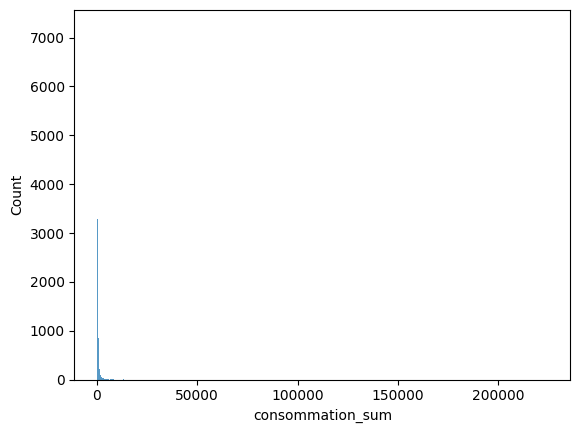

In [11]:
sns.histplot(X_train['consommation_sum'])

In [ ]:
sns.histplot(X_train['consommation_per_month'])

In [ ]:
sns.histplot(X_train['months_number'])

In [16]:
# to impute the 0 in the consommation_sum, we need to replace the 0 with nan
X_train['consommation_sum'].replace(0, np.nan, inplace=True)
X_test['consommation_sum'].replace(0, np.nan, inplace=True)

In [18]:
# numerical features
num_features = [ 'consommation_sum', 'months_number']
num_transformer = make_pipeline(
        MinMaxScaler(), # no gaussian distribution? 
        SimpleImputer(strategy='median')
    )

In [19]:
preprocessor = make_column_transformer(
        (num_transformer, num_features)
)

## Imbalanced Data

### Random Oversampler

In [ ]:
# handling the imbalanced
ros = RandomOverSampler(random_state=RSEED)
X_train, y_train = ros.fit_resample(X_train, y_train)

sns.countplot(x=y_train)

### Undersampling

In [46]:
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as imb_pipeline

In [ ]:
# SMOTE + ENN (Noise Reduction)
smote_enn = SMOTEENN(random_state=42)

smote_pipe = imb_pipe(smote_enn, preprocessor)


## Baseline model 1: Decision Tree
<span style="color:green">X_train and X_test need to have the same columns! **fixed**</span>

<span style='color:red'> In both (decision-tree & logistic regression) we have in the test data a very high accuracy in comparison to the train-data, but the ROC AUC ist lower (also the recall and precision are incredible low!)...maybe we need to check, what is our evaluation scoring?</span>

In [ ]:
#baseline model 1: Decision tree
baseline_tree = DecisionTreeClassifier(random_state=RSEED, max_depth=3)
baseline_tree.fit(X_train, y_train)

In [ ]:
print(f'Decision tree has {baseline_tree.tree_.node_count} nodes with maximum depth {baseline_tree.tree_.max_depth}.')
print(f'On average there are ca. {X_train.shape[0]/baseline_tree.tree_.node_count:.1f} data points in each leaf.')

In [ ]:
fig = plt.figure(figsize=(25,10))
dectree_plot = plot_tree(baseline_tree, filled=True)

In [ ]:
# Make probability predictions for X_train
train_probs1 = baseline_tree.predict_proba(X_train)[:, 1]
train_predictions1 = baseline_tree.predict(X_train)

In [ ]:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs1)}')

In [ ]:
print(confusion_matrix(y_train, train_predictions1))
print(classification_report(y_train, train_predictions1))

In [ ]:
# Make probability predictions test data
test_probs1 = baseline_tree.predict_proba(X_test)[:, 1]
test_predictions1 = baseline_tree.predict(X_test)

In [ ]:
print(f'Test ROC AUC Score: {roc_auc_score(y_test, test_probs1)}')

In [ ]:
print(confusion_matrix(y_test, test_predictions1))
print(classification_report(y_test, test_predictions1))

## Baseline model 2: Logistic Regression

In [ ]:
# baseline 2: logistic Regression

baseline_log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', n_jobs=1)
baseline_log_reg.fit(X_train, y_train)

# Make probability predictions for X_train
train_probs2 = baseline_log_reg.predict_proba(X_train)[:, 1]
train_predictions2 = baseline_log_reg.predict(X_train)

In [ ]:
# Results X_train prediction:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs2)}')
print(confusion_matrix(y_train, train_predictions2))
print(classification_report(y_train, train_predictions2))

In [ ]:
# Make probability predictions for X_test
test_probs2 = baseline_log_reg.predict_proba(X_test)[:, 1]
test_predictions2 = baseline_log_reg.predict(X_test)

# Results X_test prediction:
print(f'Test ROC AUC Score: {roc_auc_score(y_test, test_probs2)}')
print(confusion_matrix(y_test, test_predictions2))
print(classification_report(y_test, test_predictions2))

## HyperparameterSearch & Scoring


In [25]:
scoring = make_scorer(fbeta_score, beta=2)
cv = 5 #RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

## Model 2: Stacking

In [26]:
# Stack the models Decision Tree, KNN and SGDClassifier
estimators = [
    ('dt', DecisionTreeClassifier(random_state = RSEED)),
    ('knn', KNeighborsClassifier()),
    ('class', SGDClassifier())
]

In [27]:
pipe_st = Pipeline([
    ('preprocessor', preprocessor),
    ('st', StackingClassifier(estimators = estimators, final_estimator = LogisticRegression()))]
)

In [48]:
# SMOTE + ENN (Noise Reduction)
smote_enn = SMOTEENN(random_state=42)
smote_pipe = imb_pipeline([
    ('preprocessor', preprocessor),
    ('smoteenn', smote_enn),
    ('st', StackingClassifier(estimators = estimators, final_estimator = LogisticRegression()))]
)
smote_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['consommation_sum',
                                                   'months_number'])])),
                ('smoteenn', SMOTEENN(random_state=42)),
                ('st',
                 StackingClassifier(estimators=[('dt',
                                                 DecisionTreeClassifier(random_state=42)),
                                                ('knn', KNeighborsClassifier()),
                                                ('class', SGDClassifier())],
                                    final_estimator=LogisticRegression()))])

In [49]:
# don't forget to add the name of the model from the pipelin in front of each hyperparameter!
param_st = {'st__dt__max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'st__dt__max_leaf_nodes': [None] + list(np.arange(10, 51).astype(int)),
    'st__dt__min_samples_split': [2, 5, 10],
    'st__dt__max_depth': [None] + list(np.arange(3, 21).astype(int)),
    'st__knn__n_neighbors' : np.arange(2,50), #this actually defines the model you use
    'st__knn__weights' : ['uniform', 'distance'],
    'st__knn__p' : [1, 2, 3],
    'st__knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'st__class__penalty':('l1','l2'),
    'st__class__alpha': [0.001, 0.01, 0.1, 1, 10],
    'st__class__learning_rate': ['optimal', 'constant', 'invscaling'],
    'st__class__loss': ['log_loss', 'hinge', 'huber'],
    'st__class__max_iter' : [1000, 500],
    'st__class__eta0': [0.001, 0.01]
    }

randomsearch_st = RandomizedSearchCV(smote_pipe, param_distributions=param_st, cv=cv, scoring=scoring, n_iter=10,
                           verbose=5, n_jobs=-1) #evt. add error_score='raise'

In [50]:
randomsearch_st.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 2/5] END st__class__alpha=0.001, st__class__eta0=0.01, st__class__learning_rate=constant, st__class__loss=huber, st__class__max_iter=500, st__class__penalty=l1, st__dt__max_depth=12, st__dt__max_features=auto, st__dt__max_leaf_nodes=None, st__dt__min_samples_split=2, st__knn__algorithm=brute, st__knn__n_neighbors=17, st__knn__p=1, st__knn__weights=uniform;, score=nan total time=   1.4s
[CV 1/5] END st__class__alpha=0.001, st__class__eta0=0.01, st__class__learning_rate=constant, st__class__loss=huber, st__class__max_iter=500, st__class__penalty=l1, st__dt__max_depth=12, st__dt__max_features=auto, st__dt__max_leaf_nodes=None, st__dt__min_samples_split=2, st__knn__algorithm=brute, st__knn__n_neighbors=17, st__knn__p=1, st__knn__weights=uniform;, score=nan total time=   1.5s
[CV 3/5] END st__class__alpha=0.001, st__class__eta0=0.01, st__class__learning_rate=constant, st__class__loss=huber, st__class__max_iter=500, st__class__

/Users/katharinabaumgartner/Documents/NeueFische/scripts/24_ensembleMethods/ds-ensemble-methods/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/katharinabaumgartner/Documents/NeueFische/scripts/24_ensembleMethods/ds-ensemble-methods/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/katharinabaumgartner/Documents/NeueFische/scripts/24_ensembleMethods/ds-ensemble-methods/.venv/lib/python3.11/site-pack

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('pipeline',
                                                                               Pipeline(steps=[('minmaxscaler',
                                                                                                MinMaxScaler()),
                                                                                               ('simpleimputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['consommation_sum',
                                                                                'months_number'])])),
                                             ('smoteenn',
                                              SMOTEENN(random_state=42)),
                                             ('st',
                                              StackingClassifier(estimators=[('dt',
                                                                              DecisionTreeClas...
                                        'st__knn__algorithm': ['ball_tree',
                                                               'kd_tree',
                                                               'brute'],
                                        'st__knn__n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'st__knn__p': [1, 2, 3],
                                        'st__knn__weights': ['uniform',
                                                             'distance']},
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
                   verbose=5)

In [51]:
# Show best parameters
print('Best score:\n{:.2f}'.format(randomsearch_st.best_score_))
print("Best parameters:\n{}".format(randomsearch_st.best_params_))

Best score:
0.22
Best parameters:
{'st__knn__weights': 'uniform', 'st__knn__p': 2, 'st__knn__n_neighbors': 32, 'st__knn__algorithm': 'ball_tree', 'st__dt__min_samples_split': 2, 'st__dt__max_leaf_nodes': 48, 'st__dt__max_features': 'sqrt', 'st__dt__max_depth': 9, 'st__class__penalty': 'l1', 'st__class__max_iter': 500, 'st__class__loss': 'log_loss', 'st__class__learning_rate': 'optimal', 'st__class__eta0': 0.001, 'st__class__alpha': 0.01}


In [52]:
# Save best model (including fitted preprocessing steps) as best_model_st
best_model_st = randomsearch_st.best_estimator_
best_model_st

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['consommation_sum',
                                                   'months_number'])])),
                ('smoteenn', SMOTEENN(random_state=42)),
                ('st',
                 StackingClassifier(estimators=[('dt',
                                                 DecisionTreeClassifier(max_depth=9,
                                                                        max_features='sqrt',
                                                                        max_leaf_nodes=48,
                                                                        random_state=42)),
                                                ('knn',
                                                 KNeighborsClassifier(algorithm='ball_tree',
                                                                      n_neighbors=32)),
                                                ('class',
                                                 SGDClassifier(alpha=0.01,
                                                               eta0=0.001,
                                                               loss='log_loss',
                                                               max_iter=500,
                                                               penalty='l1'))],
                                    final_estimator=LogisticRegression()))])

In [53]:
best_model_st.score(X_test, y_test)

0.8724267512393606

In [54]:
test_predictions_1 = best_model_st.predict(X_test)

In [55]:
print(confusion_matrix(y_test, test_predictions_1))
print(classification_report(y_test, test_predictions_1))

[[969891  60618]
 [ 82101   6112]]
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93   1030509
         1.0       0.09      0.07      0.08     88213

    accuracy                           0.87   1118722
   macro avg       0.51      0.51      0.51   1118722
weighted avg       0.86      0.87      0.86   1118722



In [56]:
test_probs_1 = best_model_st.predict_proba(X_test)[:, 1]


In [57]:
print(f'Test ROC AUC Score: {roc_auc_score(y_test, test_probs_1)}')

Test ROC AUC Score: 0.5090593874801974


In [58]:
# Make predictions for X_train
train_probs_2 = best_model_st.predict_proba(X_train)[:, 1]
train_predictions_2 = best_model_st.predict(X_train)

In [59]:
# Results X_train prediction:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs_2)}')
print(confusion_matrix(y_train, train_predictions_2))
print(classification_report(y_train, train_predictions_2))

Train ROC AUC Score: 0.7658545721235135
[[88016 38372]
 [ 2292  5260]]
              precision    recall  f1-score   support

         0.0       0.97      0.70      0.81    126388
         1.0       0.12      0.70      0.21      7552

    accuracy                           0.70    133940
   macro avg       0.55      0.70      0.51    133940
weighted avg       0.93      0.70      0.78    133940



## Evaluate the models

In [ ]:
#NOCH ANZUPASSEN!


def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
   baseline_tree = {}
    
   baseline_tree['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
   baseline_tree['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
   baseline_tree['roc'] = roc_auc_score(y_test, y_probs)

   baseline_log_reg = {}
    
   baseline_log_reg['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
   baseline_log_reg['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
   baseline_log_reg['roc'] = roc_auc_score(y_test, y_probs)
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');